# WI Performance Incentives for Reducing Revocations

See [this folder](https://drive.google.com/drive/folders/1bhEJrcFBw3lj3jF0qo2vKoi60XKg5_hG) for details.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.transitions_utils import TransitionTableType

import pandas as pd
from functools import partial
import yaml

## Policy modeling

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/WI/WI_prison_model_inputs.yaml')

/Users/zack/.local/share/virtualenvs/pulse-data-trReGjBw/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|██████████| 240/240 [00:00<00:00, 1137.88rows/s]


outflows_data returned 240 results


Downloading: 100%|██████████| 393/393 [00:00<00:00, 1905.89rows/s]


transitions_data returned 393 results


Downloading: 100%|██████████| 240/240 [00:00<00:00, 1134.95rows/s]

total_population_data returned 240 results


initialization time:  6.472368955612183
simulation_time:  6.23377799987793


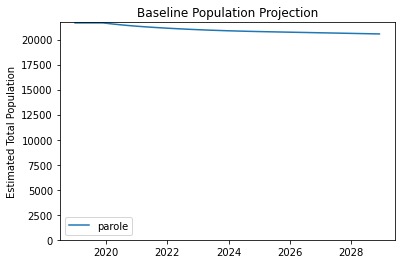

In [4]:
test_sim.simulate_baseline(['parole'])

initialization time:  6.599046945571899
initialization time:  6.002906322479248
simulation_time:  6.004591941833496
simulation_time:  6.618948221206665


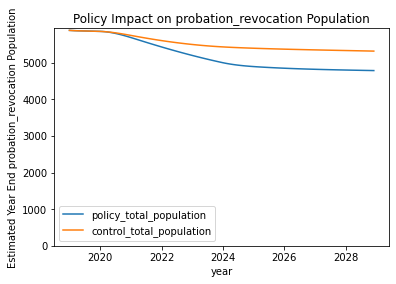

In [5]:
# test_sim = SuperSimulationFactory.build_super_simulation('../state/WI/WI_prison_model_inputs.yaml')

# Policy Option Methods
revocation_outflows = {
    'parole': 'parole_revocation',
    'probation': 'probation_revocation'
}
REVOCATION_REDUCTION = 0.10 # .1, .2, .3

def incentivize_completions(reduction, compartment, retroactive=False):
    return partial(TransitionTable.reallocate_outflow,
                   reallocation_df=pd.DataFrame({
                       'outflow':[revocation_outflows[compartment]],
                       'affected_fraction': [reduction],
                       'new_outflow': ['release']
                   }),
                   reallocation_type='*',
                   retroactive=retroactive)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                spark_compartment=compartment,
                sub_population={'crime_type': 'x'},
                policy_ts=12*10 + 1,
                apply_retroactive=False)
    for compartment in revocation_outflows
]
    
test_results = test_sim.simulate_policy(
    policy_list_non_retroactive, 'probation_revocation'
)

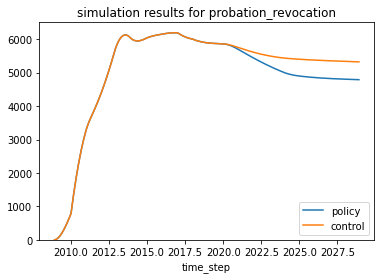

In [6]:
DISPLAY_COMPARTMENTS=['probation_revocation']

######################################################################################################################

policy_populations = test_sim.simulator.pop_simulations['policy'].population_projections
policy_populations = [policy_populations[policy_populations.compartment == i] for i in DISPLAY_COMPARTMENTS]

control_populations = test_sim.simulator.pop_simulations['control'].population_projections
control_populations = [control_populations[control_populations.compartment == i] for i in DISPLAY_COMPARTMENTS]

reference_year = test_sim.initializer.time_converter.reference_year
time_step = test_sim.initializer.time_converter.get_time_step()

for compartment_idx, compartment in enumerate(DISPLAY_COMPARTMENTS):
    display_df = pd.DataFrame()
    display_df['policy'] = policy_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df['control'] = control_populations[compartment_idx].groupby('time_step').sum().total_population
    display_df.index = test_sim.initializer.time_converter.convert_time_steps_to_year(pd.Series(display_df.index))
    display_df.plot(title=f'simulation results for {compartment}', ylim=[0, None])

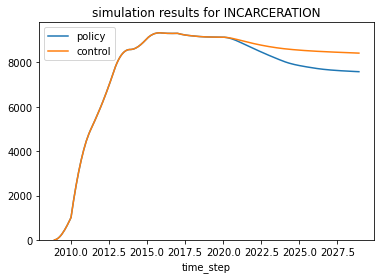

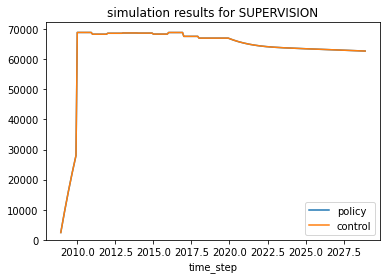

In [7]:
INCARCERATION_COMPARTMENTS = ['parole_revocation', 'probation_revocation']
SUPERVISION_COMPARTMENTS = ['parole', 'probation']

######################################################################################################################


policy_populations = test_sim.simulator.pop_simulations['policy'].population_projections
policy_populations = [policy_populations[policy_populations.compartment.apply(lambda x: x in INCARCERATION_COMPARTMENTS)],
                      policy_populations[policy_populations.compartment.apply(lambda x: x in SUPERVISION_COMPARTMENTS)],]

control_populations = test_sim.simulator.pop_simulations['control'].population_projections
control_populations = [control_populations[control_populations.compartment.apply(lambda x: x in INCARCERATION_COMPARTMENTS)],
                      control_populations[control_populations.compartment.apply(lambda x: x in SUPERVISION_COMPARTMENTS)],]

reference_year = test_sim.initializer.time_converter.reference_year
time_step = test_sim.initializer.time_converter.get_time_step()

for group_idx, group in enumerate(['INCARCERATION', 'SUPERVISION']):
    display_df = pd.DataFrame()
    display_df['policy'] = policy_populations[group_idx].groupby('time_step').sum().total_population
    display_df['control'] = control_populations[group_idx].groupby('time_step').sum().total_population
    display_df.index = test_sim.initializer.time_converter.convert_time_steps_to_year(pd.Series(display_df.index))
    display_df.plot(title=f'simulation results for {group}', ylim=[0, None])


## old

In [ ]:
simulation_tag = 'WI_PO_incentives_30%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [ ]:
for r in [0.1, 0.2]:
    
    # Policy Option Methods
    # revocation_outflows = same as before
    REVOCATION_REDUCTION = r

    policy_list_non_retroactive = [
        SparkPolicy(policy_fn=incentivize_completions(REVOCATION_REDUCTION, compartment),
                    spark_compartment=compartment,
                    sub_population={'crime_type': 'x'},
                    apply_retroactive=False)
        for compartment in revocation_outflows
    ]

    test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'parole_revocation')
    
    simulation_tag = 'WI_PO_incentives_{}%'.format(int(r * 100))
    test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)